# IA for HumanForYou

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

* Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

* Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

* Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

### Données fournies

Un certain nombre de données concernant les employés vous a donc été transmis par le service des ressources humaines.

Il s'agit de fichiers textes au format CSV.

Les données ont été anonymisées : un employé de l'entreprise sera représenté par le même EmployeeID dans l'ensemble des fichiers qui suivent.

### Données du service des ressources humaines

Pour chaque employé, le service des ressources humaines vous confie les informations en sa possession :

 - Age : L'âge de l'employé en 2015.

 - Attrition : L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?

 - BusinessTravel : A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)

 - DistanceFromHome : Distance en km entre le logement de l'employé et l'entreprise.

 - Education : Niveau d'étude : 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).

 - EducationField : Domaine d'étude, matière principale

 - EmployeeCount : booléen à 1 si l'employé était compté dans les effectifs en 2015.

 - EmployeeId : l'identifiant d'un employé

 - Gender : Sexe de l'employé

 - JobLevel : Niveau hiérarchique dans l'entreprise de 1 à 5

 - JobRole : Métier dans l'entreprise

 - MaritalStatus : Statut marital du salarié (Célibataire, Marié ou Divorcé).

 - MonthlyIncome : Salaire brut en roupies par mois

 - NumCompaniesWorked : Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.

 - Over18 : Est-ce que le salarié a plus de 18 ans ou non ?

 - PercentSalaryHike : % d'augmentation du salaire en 2015.

 - StandardHours : Nombre d'heures par jour dans le contrat du salarié.

 - StockOptionLevel : Niveau d'investissement en actions de l'entreprise par le salarié.

 - TotalWorkingYears : Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.

 - TrainingTimesLastYear : Nombre de jours de formation en 2015

 - YearsAtCompany : Ancienneté dans l'entreprise

 - YearsSinceLastPromotion : Nombre d'années depuis la dernière augmentation individuelle

 - YearsWithCurrentManager : Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

### Importation des données utiles 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import os
import datetime as dt

import tarfile
import zipfile
import urllib.request
from six.moves import urllib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from  sklearn.svm import SVC
from sklearn.metrics import log_loss, make_scorer
import math 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve 
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
#from prettytable import PrettyTable

In [2]:
from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(42) 


DOWNLOAD_ROOT = "https://github.com/Killian-drh/Projet-IA/raw/main/datasets/inoutime/"
INOUTPATH = os.path.join("datasets", "inoutime")
DATA_PATH = "./datasets/"
INOUTIME_URL = DOWNLOAD_ROOT + "in_out_time.zip"

def check_image_folder():
    if not os.path.exists("./images/"):
        os.makedirs("./images/")
        os.makedirs("./images/workflowDS/")
        print ("Images and workflowDS folder has been created")
    elif os.path.exists("./images/"):
        if not os.path.exists("./images/workflowDS/"):
            os.makedirs("./images/workflowDS/")
            print ("WorkflowDS folder has been created")


def fetch_inoutime_data(inoutime_url=INOUTIME_URL, data_path=INOUTPATH):
    in_out_time_check = data_path + "/in_out_time.zip"
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
    if not os.path.exists(in_out_time_check):
        # Download in_out_time.zip from repo github
        zip_path = os.path.join(data_path, "in_out_time.zip")
        urllib.request.urlretrieve(inoutime_url, zip_path)    
        print ("Download Succeed !")

    # specifying the zip file name 
    file_name = './datasets/inoutime/in_out_time.zip'
    
    in_time_check = os.path.exists("./datasets/inoutime/in_time.csv")
    out_time_check = os.path.exists("./datasets/inoutime/out_time.csv")
    
    if in_time_check==False or out_time_check==False: 
    # opening the zip file in READ mode 
        with zipfile.ZipFile(file_name, 'r') as zip: 
          #  printing all the contents of the zip file 
            zip.printdir() 
  
        # extracting all the files 
            print('Extracting all the files now...') 
            zip.extractall(data_path) 
            print('Done!') 
            
    print("Process succeed")
    
check_image_folder()
fetch_inoutime_data()

def load_data(file, data_path=DATA_PATH):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path)

general_df = load_data("general_data.csv")
manager_survey_df = load_data("manager_survey_data.csv")
employee_survey_df = load_data("employee_survey_data.csv")
intime_df = pd.read_csv("./datasets/inoutime/in_time.csv")
outtime_df = pd.read_csv("./datasets/inoutime/out_time.csv")

Process succeed


### Fusion des fichiers csv selon l'ID employé

In [3]:
print(general_df.shape ,  manager_survey_df.shape ,  employee_survey_df.shape)
print(employee_survey_df.columns.tolist())
print(manager_survey_df.columns.tolist())

(4410, 24) (4410, 3) (4410, 4)
['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
['EmployeeID', 'JobInvolvement', 'PerformanceRating']


In [4]:
df_merge=pd.merge(general_df,employee_survey_df,on='EmployeeID')
df=pd.merge(df_merge,manager_survey_df,on='EmployeeID')

if(len(df.columns.tolist())   == (len(general_df.columns.tolist()) + len(employee_survey_df.columns.tolist()) + len(manager_survey_df.columns.tolist())) - 2):
  print("OK")

OK


In [5]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


Le fichier est a présent complet

### Recheche de valeur null

In [6]:
print("finding whether is there is any nulls in the final_df  if yes how many  {}".format(df.isnull().sum().sum()))
df.dropna(inplace=True)
print("finding whether is there is any nulls in after droping the  final_df  if yes how many  {}".format(df.isnull().any().sum()))

finding whether is there is any nulls in the final_df  if yes how many  111
finding whether is there is any nulls in after droping the  final_df  if yes how many  0


### Recherche de valeur duplication

In [7]:
df_duplicatedRows=df[df.duplicated( keep=False)].shape[0]
if(df_duplicatedRows==0):
  print("Pas de duplicat dans df")
else:
  print("Duplicat dans df")

Pas de duplicat dans df


### Analyse des données

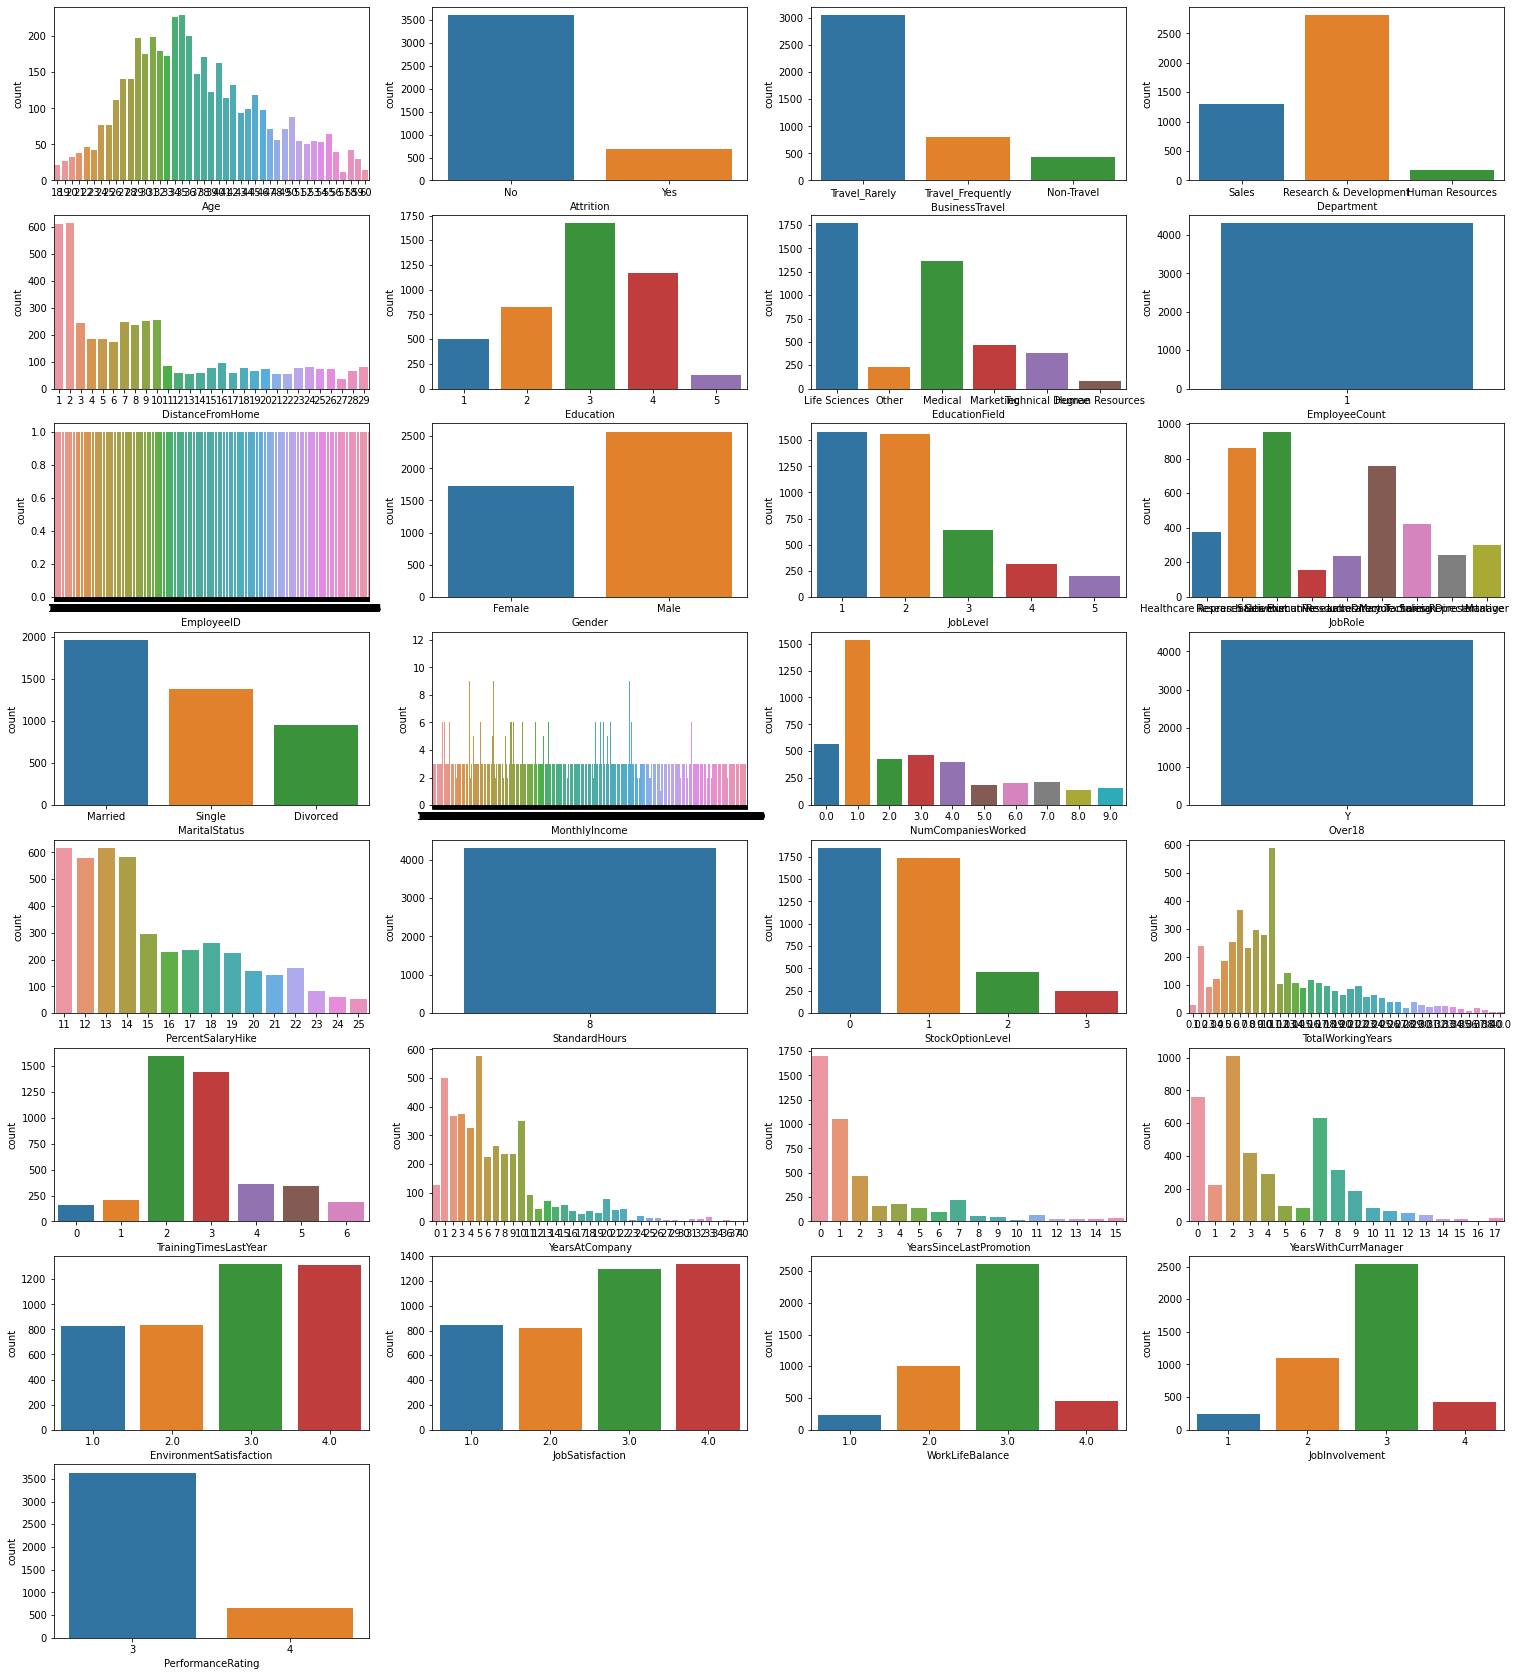

In [8]:
#For all columns doing countplots
fig = plt.figure(figsize=(26,30))
for idx,i in enumerate(df.columns.tolist()):
    ax=plt.subplot(8,4,idx+1)
    sns.countplot(x=i,data=df,ax=ax)
plt.show()

## Analyse des données  | EDA ("Eploratory Data Analysis")

### Analyse des données quantitaves

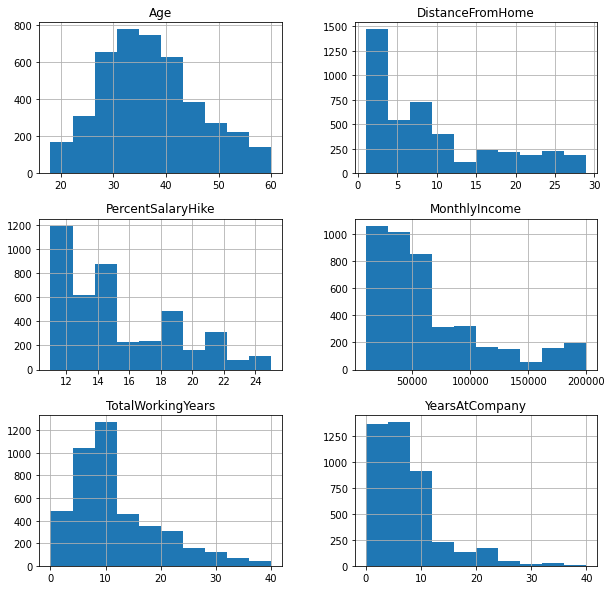

In [9]:
#Divide into NumericalColumns
columns=df.columns.tolist()
num_col_eda=['Age','DistanceFromHome','PercentSalaryHike','MonthlyIncome','TotalWorkingYears','YearsAtCompany']
df[num_col_eda].hist(figsize=(10,10))
plt.show()

### Analyse des données qualitatives

In [10]:
num_attrition=num_col_eda+['Attrition']
Education=['Below-College','College','Bachelor','Master','Doctor']
EnvironmentSatisfaction=['Low','Medium','High','Very High']
JobInvolvement=['Low','Medium','High','Very High']
JobSatisfaction=['Low','Medium','High','Very High']
RelationshipSatisfaction=['Low','Medium','High','Very High']
PerformanceRating=['Low','Good','Excellent','Outstanding']
WorkLifeBalance=['Bad','Good','Better','Best']

val=[Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,WorkLifeBalance]
cat1=['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating','WorkLifeBalance']

cat_col_eda=set(columns) - set(num_col_eda)
cat_col_eda=set(cat_col_eda) - set(cat1)
#fig = plt.figure(figsize=(16,20))

#### for Ordinal Columns doing uni_variant analysis


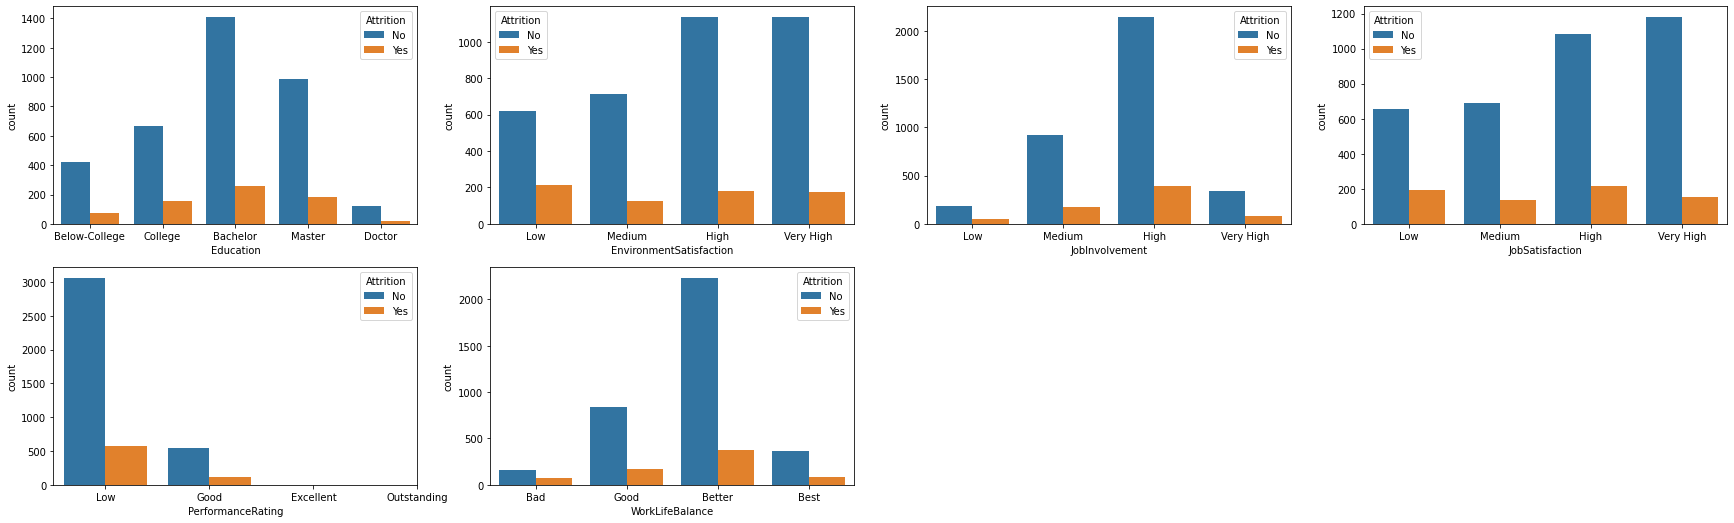

In [11]:
fig = plt.figure(figsize=(30,28))
for idx,i in enumerate(zip(cat1,val)):
    ax=plt.subplot(6,4,idx+1)
    sns.countplot(df[i[0]],hue=df['Attrition'],ax=ax)
    ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

#### for nominal_column doing univariant analysis

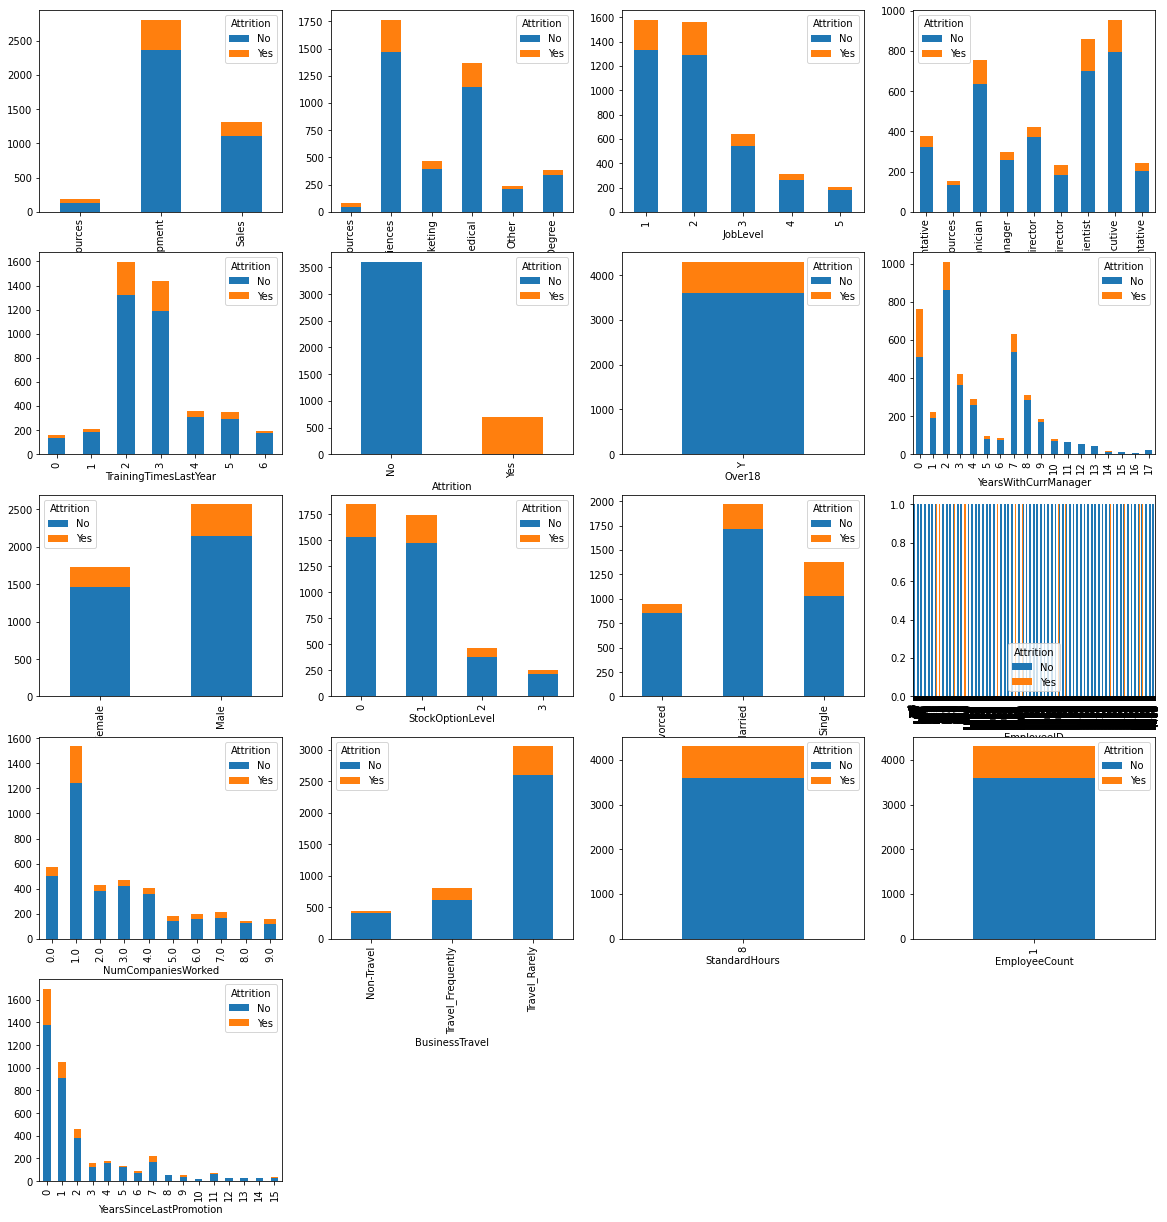

In [12]:

#Divide into CategoricalColumns
#1. with categorys as x_ticks
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(cat_col_eda):
    crosstab = pd.crosstab(index=df[i], columns=df["Attrition"])
    ax=plt.subplot(6,4,idx+1)
    crosstab.plot(kind="bar",stacked=True,ax=ax)
    #sns.countplot(x=i[0],data=final_df,ax=ax)
    #ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

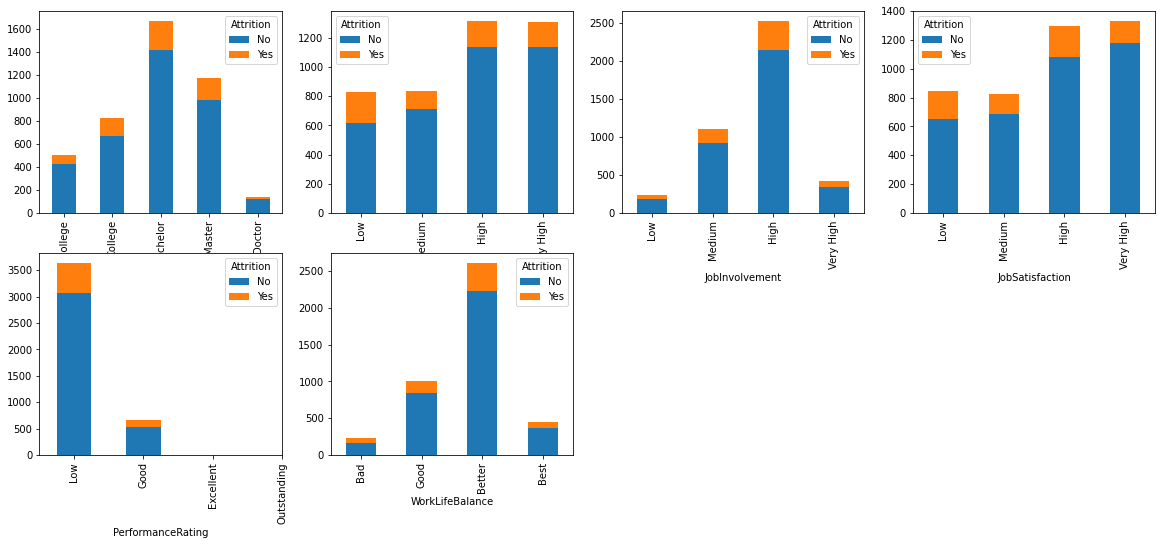

In [13]:
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(zip(cat1,val)):
    crosstab = pd.crosstab(index=df[i[0]], columns=df["Attrition"])
    ax=plt.subplot(6,4,idx+1)
    crosstab.plot(kind="bar",stacked=True,ax=ax)
    #sns.countplot(x=i[0],data=final_df,ax=ax)
    ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

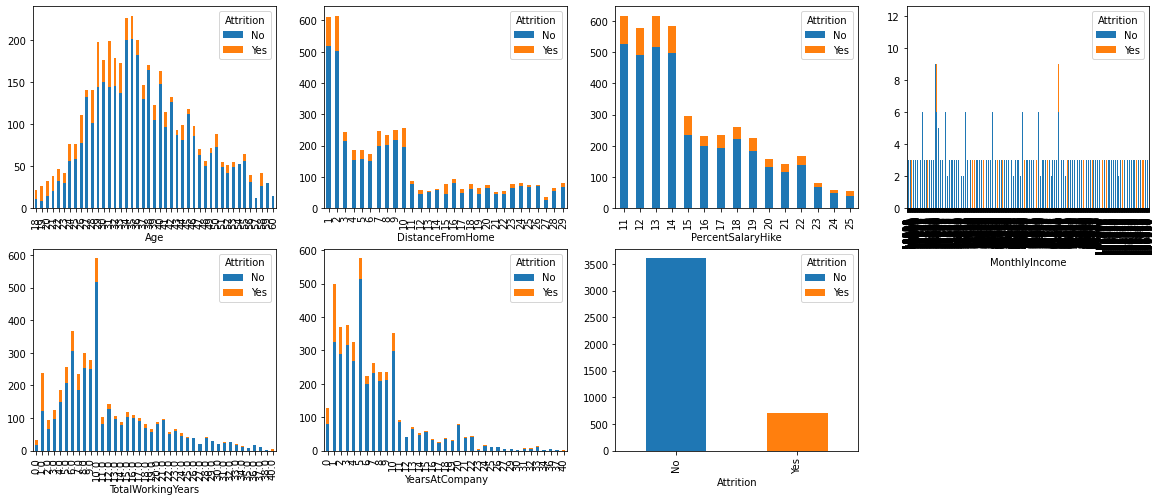

In [14]:
#for i in num_attrition:
#crosstab = pd.crosstab(index=final_df[i], columns=final_df["Attrition"])
#num_attrition=num_col_eda+['Attrition']
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(num_attrition):
  crosstab = pd.crosstab(index=df[i], columns=df["Attrition"])
  ax=plt.subplot(6,4,idx+1)
    #sns.boxplot(x=i,data=final_df,ax=ax)
  
  crosstab.plot(kind="bar",stacked=True,ax=ax)

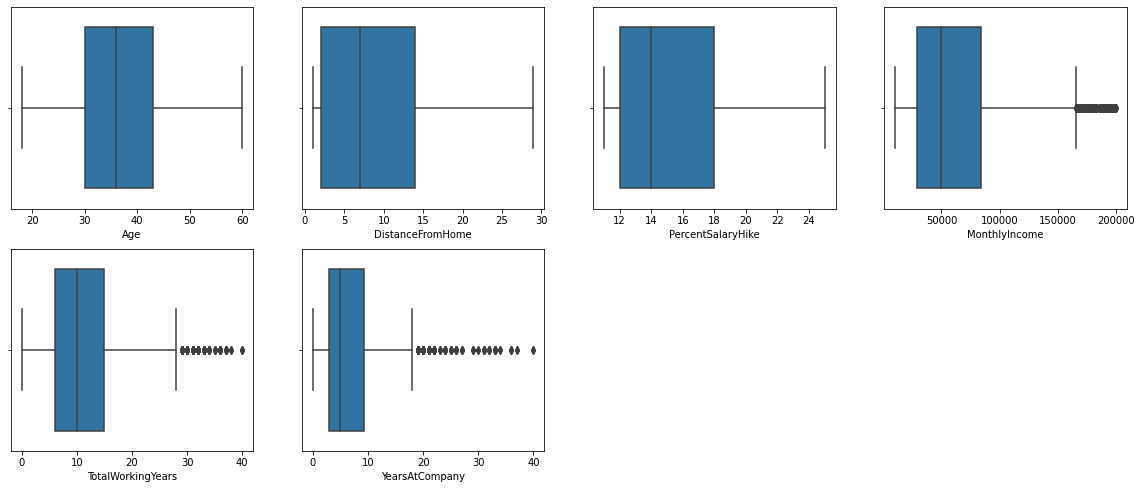

In [15]:
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(num_col_eda):
    ax=plt.subplot(6,4,idx+1)
    sns.boxplot(x=i,data=df,ax=ax)

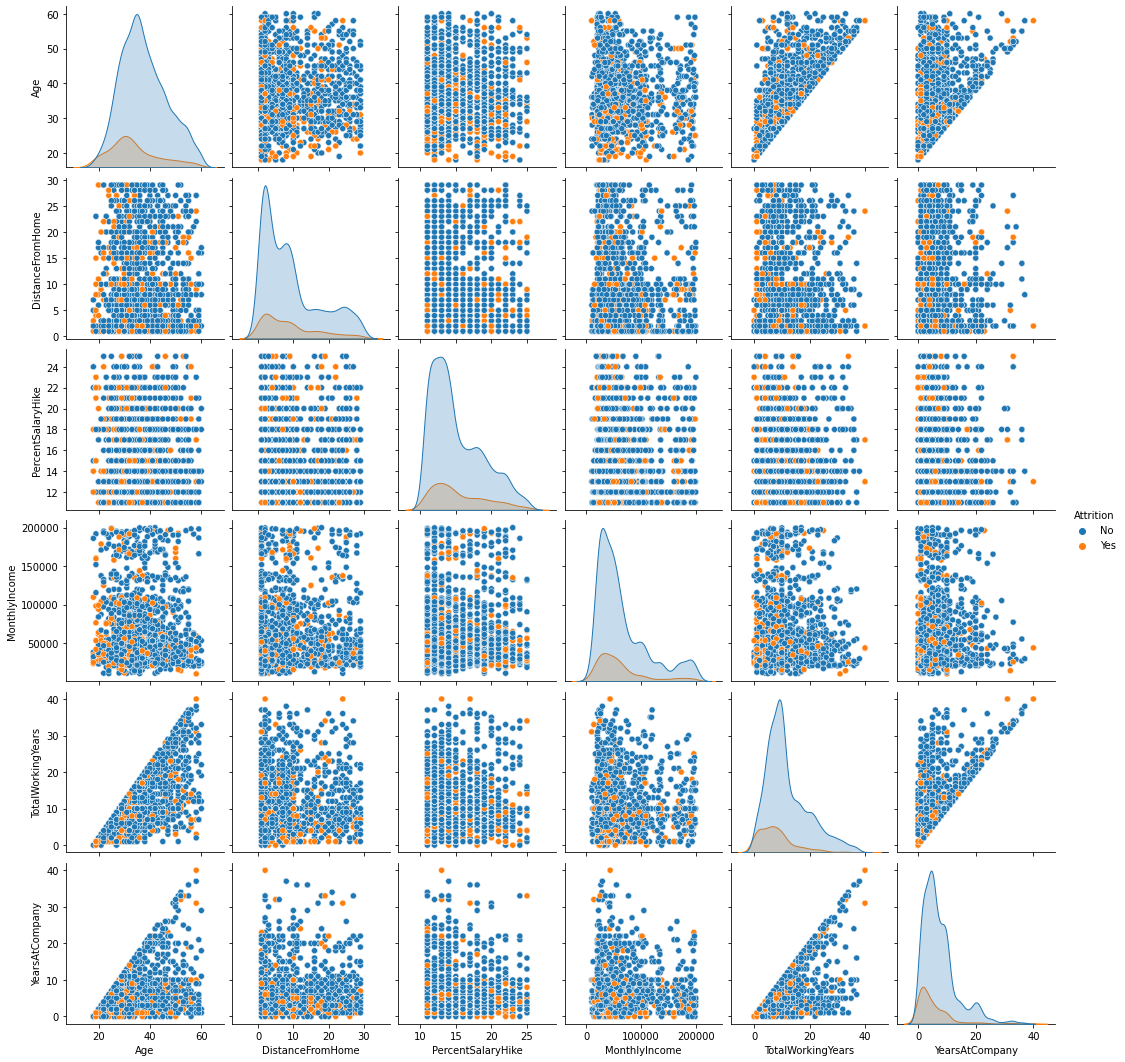

In [16]:
sns.pairplot(df[num_attrition], hue = 'Attrition')

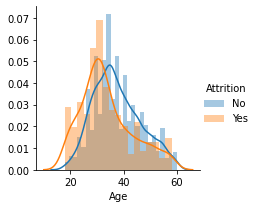

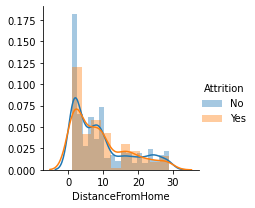

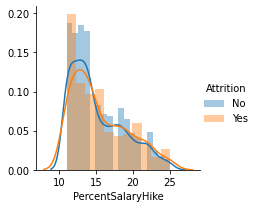

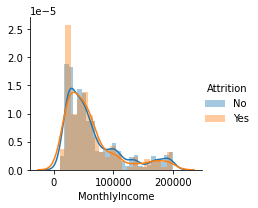

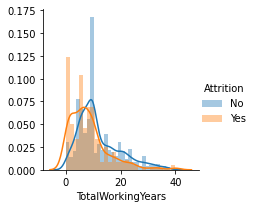

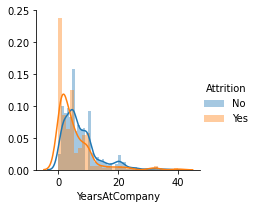

ValueError: could not convert string to float: 'No'

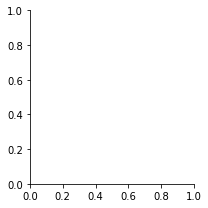

In [17]:
for i in num_attrition:
  sns.FacetGrid(df,hue="Attrition",size=3).map(sns.distplot,i).add_legend()
  plt.show()

### Extraction de données utiles (Age et Attrition)

In [18]:
df['age_fs']=df['Age'].map(lambda x: "20" if(x<30) else ("30" if(30<=x<40) else ("40" if(40<=x<50) else "50")))
df['age_fs1']=df['Age'].map(lambda x: "20-40" if(x<40) else "40-60")

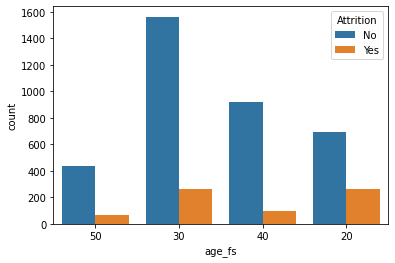

In [19]:
sns.countplot(df["age_fs"],hue=df['Attrition'])
plt.show()

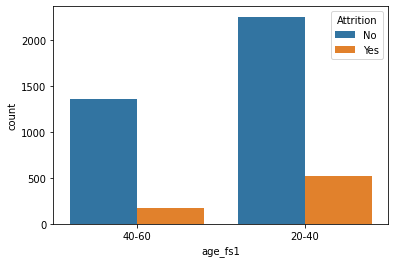

In [20]:
sns.countplot(df["age_fs1"],hue=df['Attrition'])
plt.show()

### Recherche de coorélation entre les données analysées

In [21]:
df_numerical_data = df.copy()
df_numerical_data.drop(['EmployeeCount','StandardHours'], inplace=True, axis=1)

<AxesSubplot:>

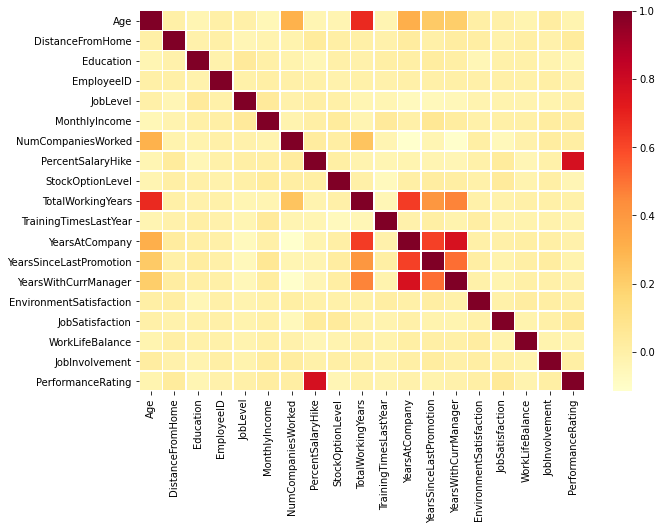

In [22]:
fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(df_numerical_data.corr(),cmap='YlOrRd',linewidths=.5,ax=ax)

## Entrainement de l'algorithme

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

attrition_label=df['Attrition']
df_train = df.copy()
df_train=df_train.drop('Attrition',1)

attrition_label=attrition_label.map(lambda x : 1 if(x=='Yes') else 0)


X_train, X_test, y_train, y_test = train_test_split(df_train,attrition_label,test_size=0.20,stratify=attrition_label, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train,test_size=0.20,stratify=y_train, random_state=42)

In [24]:
X_train=pd.get_dummies(X_train)
X_cv=pd.get_dummies(X_cv)
X_test=pd.get_dummies(X_test)

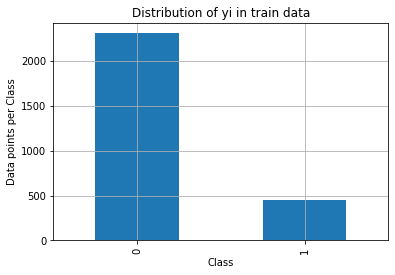

Number of data points in class 0 : 2307 ( 83.83 %)
Number of data points in class 1 : 445 ( 16.17 %)
--------------------------------------------------------------------------------


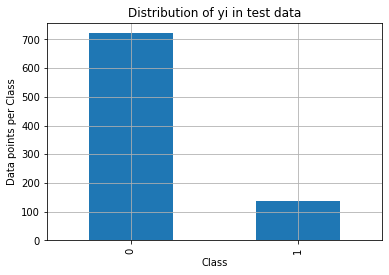

Number of data points in class 1 : 721 ( 83.837 %)
Number of data points in class 2 : 139 ( 16.163 %)
--------------------------------------------------------------------------------


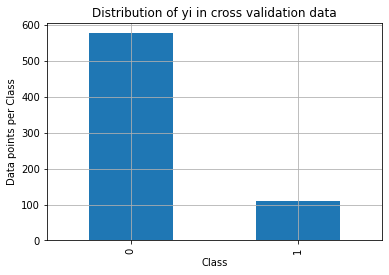

Number of data points in class 1 : 577 ( 83.866 %)
Number of data points in class 2 : 111 ( 16.134 %)


In [25]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()
cv_class_distribution = y_cv.value_counts()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')